# P03_05_Multivar_LSTM

In [1]:
section_fig_main_title = 'P03_05_Multivar_LSTM_'

In [2]:
!which python

/Users/amin/miniconda3/bin/python


In [3]:
import os, sys
import requests
from urllib.parse import urljoin, urlparse
# from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import lag_plot

from tensorflow import keras

In [4]:
from sklearn.metrics import r2_score
from math import sqrt
import json

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
# !/Users/amin/Desktop/proj/env/bin/python -m pip install xgboost

In [6]:
from sklearn.metrics import r2_score,mean_absolute_error

In [7]:
# !/Users/amin/anaconda3/bin/python -m pip install --upgrade tensorflow 
# pip install --upgrade tensorflow 

In [8]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

import math
from sklearn.metrics import mean_squared_error

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [11]:
from pandas.plotting import autocorrelation_plot
import gif

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [13]:
import tensorflow as tf
tf.__version__


'2.6.0'

In [14]:
import gif
from tqdm import tqdm

In [15]:
from sklearn import metrics
import statsmodels.api as sm

## Read Data 

Using the univariate evenly spaced time series data from P03_01.

In [15]:
csv_path = "../Data/Data_ICME_Edited_Decoded_out_P02_03.csv"
df = pd.read_csv(csv_path)

In [16]:
df.index = df['ICME Plasma/Field Start Y/M/D (UT) (b)']

In [17]:
df.head()

,ICME Plasma/Field Start Y/M/D (UT) (b),ICME Plasma/Field End Y/M/D (UT) (b),BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),V_max (km/s) (j),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
ICME Plasma/Field Start Y/M/D (UT) (b),,,,,,,,,,,
1996-05-27 15:00:00,1996-05-27 15:00:00,1996-05-29 03:00:00,1,2,1,370,400,9,3,117,1.375000
1996-07-01 18:00:00,1996-07-01 18:00:00,1996-07-02 11:00:00,1,4,44,360,370,11,3,78,0.583333
1996-08-07 12:00:00,1996-08-07 12:00:00,1996-08-08 10:00:00,1,2,2,350,380,7,3,88,0.791667
1996-12-23 17:00:00,1996-12-23 17:00:00,1996-12-25 11:00:00,1,2,22,360,420,10,3,69,1.625000
1997-01-10 04:00:00,1997-01-10 04:00:00,1997-01-11 02:00:00,3,1,4,450,460,14,3,191,0.791667


<AxesSubplot:xlabel='ICME Plasma/Field Start Y/M/D (UT) (b)'>

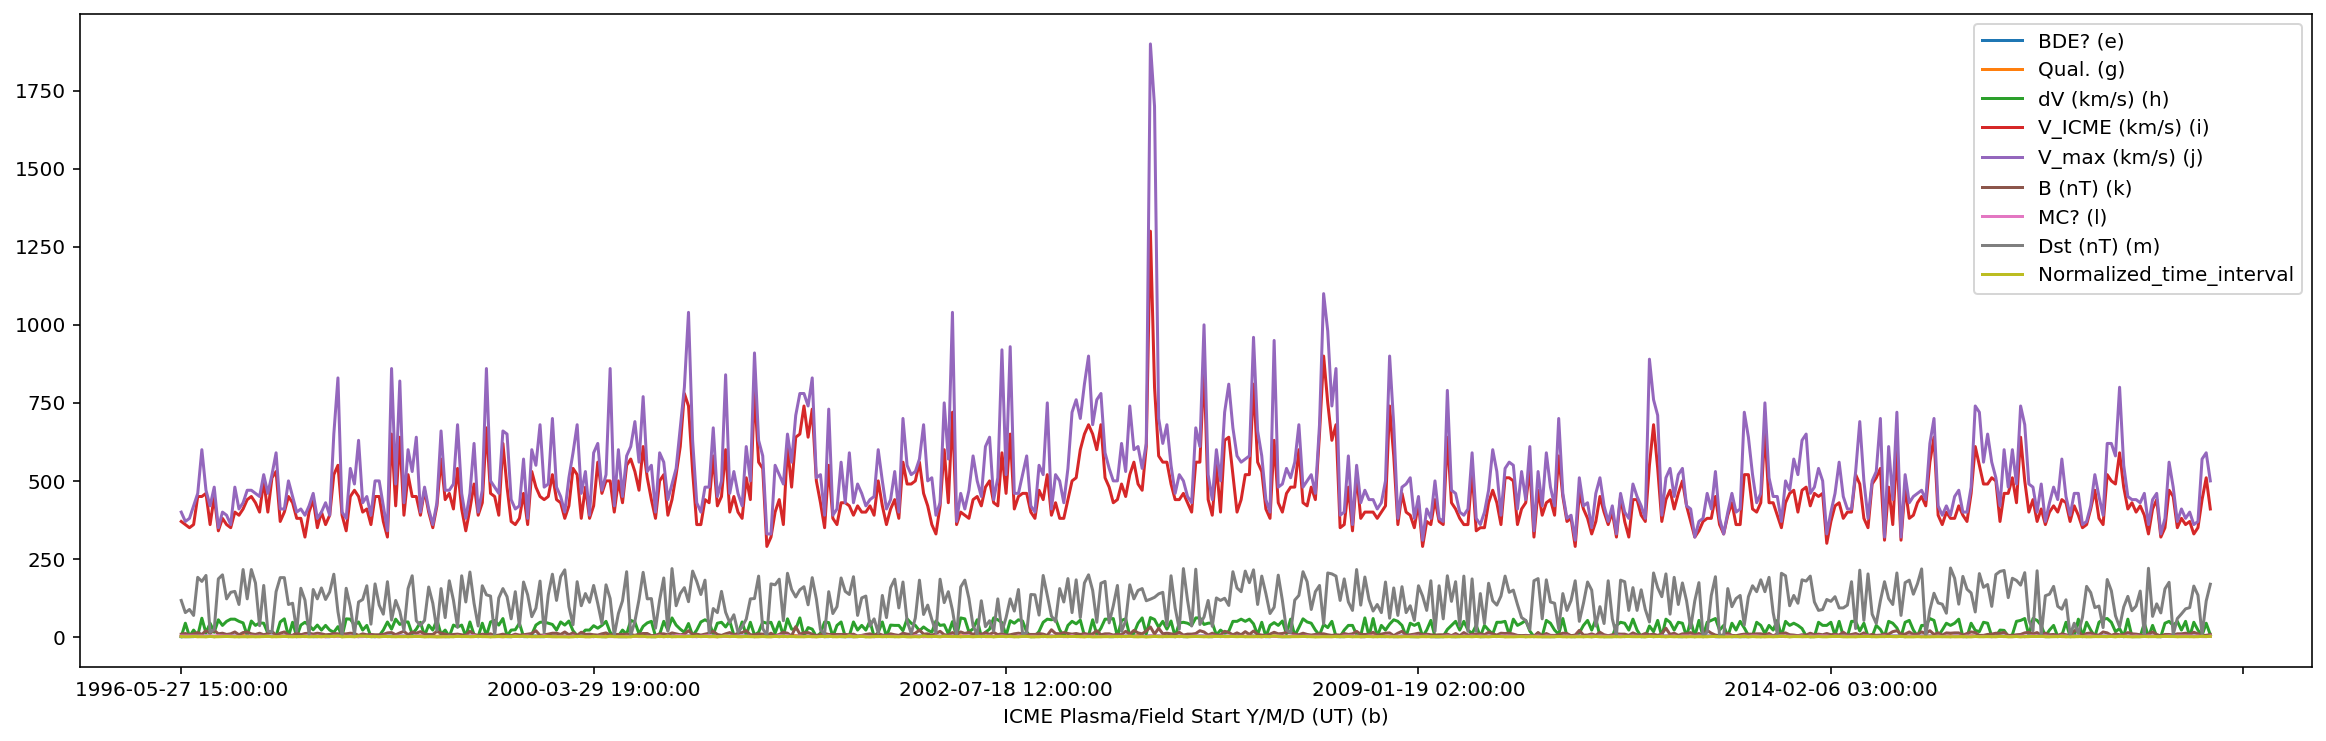

In [18]:
df.plot(figsize=(20,6))

In [19]:
df.columns

Index(['ICME Plasma/Field Start Y/M/D (UT) (b)',
       'ICME Plasma/Field End Y/M/D (UT) (b)', 'BDE? (e)', 'Qual. (g)',
       'dV (km/s) (h)', 'V_ICME (km/s) (i)', 'V_max (km/s) (j)', 'B (nT) (k)',
       'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval'],
      dtype='object')

In [22]:
keep_cols = ['ICME Plasma/Field Start Y/M/D (UT) (b)', 'BDE? (e)', 'Qual. (g)',
       'dV (km/s) (h)', 'V_ICME (km/s) (i)', 'B (nT) (k)',
       'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval']
df = df[keep_cols]
df.head()

,ICME Plasma/Field Start Y/M/D (UT) (b),BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
ICME Plasma/Field Start Y/M/D (UT) (b),,,,,,,,,
1996-05-27 15:00:00,1996-05-27 15:00:00,1,2,1,370,9,3,117,1.375000
1996-07-01 18:00:00,1996-07-01 18:00:00,1,4,44,360,11,3,78,0.583333
1996-08-07 12:00:00,1996-08-07 12:00:00,1,2,2,350,7,3,88,0.791667
1996-12-23 17:00:00,1996-12-23 17:00:00,1,2,22,360,10,3,69,1.625000
1997-01-10 04:00:00,1997-01-10 04:00:00,3,1,4,450,14,3,191,0.791667


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 493 entries, 1996-05-27 15:00:00 to 2021-05-12 15:00:00
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ICME Plasma/Field Start Y/M/D (UT) (b)  493 non-null    object 
 1   BDE? (e)                                493 non-null    int64  
 2   Qual. (g)                               493 non-null    int64  
 3   dV (km/s) (h)                           493 non-null    int64  
 4   V_ICME (km/s) (i)                       493 non-null    int64  
 5   B (nT) (k)                              493 non-null    int64  
 6   MC? (l)                                 493 non-null    int64  
 7   Dst (nT) (m)                            493 non-null    int64  
 8   Normalized_time_interval                493 non-null    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 38.5+ KB


## Split the data

In [25]:
split_fraction = 0.69
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 60
future = 1
learning_rate = 0.001
batch_size = 256
epochs = 10

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [26]:
selected_features = ['BDE? (e)', 'Qual. (g)',
                   'dV (km/s) (h)', 'V_ICME (km/s) (i)', 'B (nT) (k)',
                   'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval']

features = df[selected_features]
features.index = df.index

In [27]:
features.head()

,BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
ICME Plasma/Field Start Y/M/D (UT) (b),,,,,,,,
1996-05-27 15:00:00,1,2,1,370,9,3,117,1.375000
1996-07-01 18:00:00,1,4,44,360,11,3,78,0.583333
1996-08-07 12:00:00,1,2,2,350,7,3,88,0.791667
1996-12-23 17:00:00,1,2,22,360,10,3,69,1.625000
1997-01-10 04:00:00,3,1,4,450,14,3,191,0.791667


In [28]:
features.shape

(493, 8)

In [29]:
df.columns

Index(['ICME Plasma/Field Start Y/M/D (UT) (b)', 'BDE? (e)', 'Qual. (g)',
       'dV (km/s) (h)', 'V_ICME (km/s) (i)', 'B (nT) (k)', 'MC? (l)',
       'Dst (nT) (m)', 'Normalized_time_interval'],
      dtype='object')

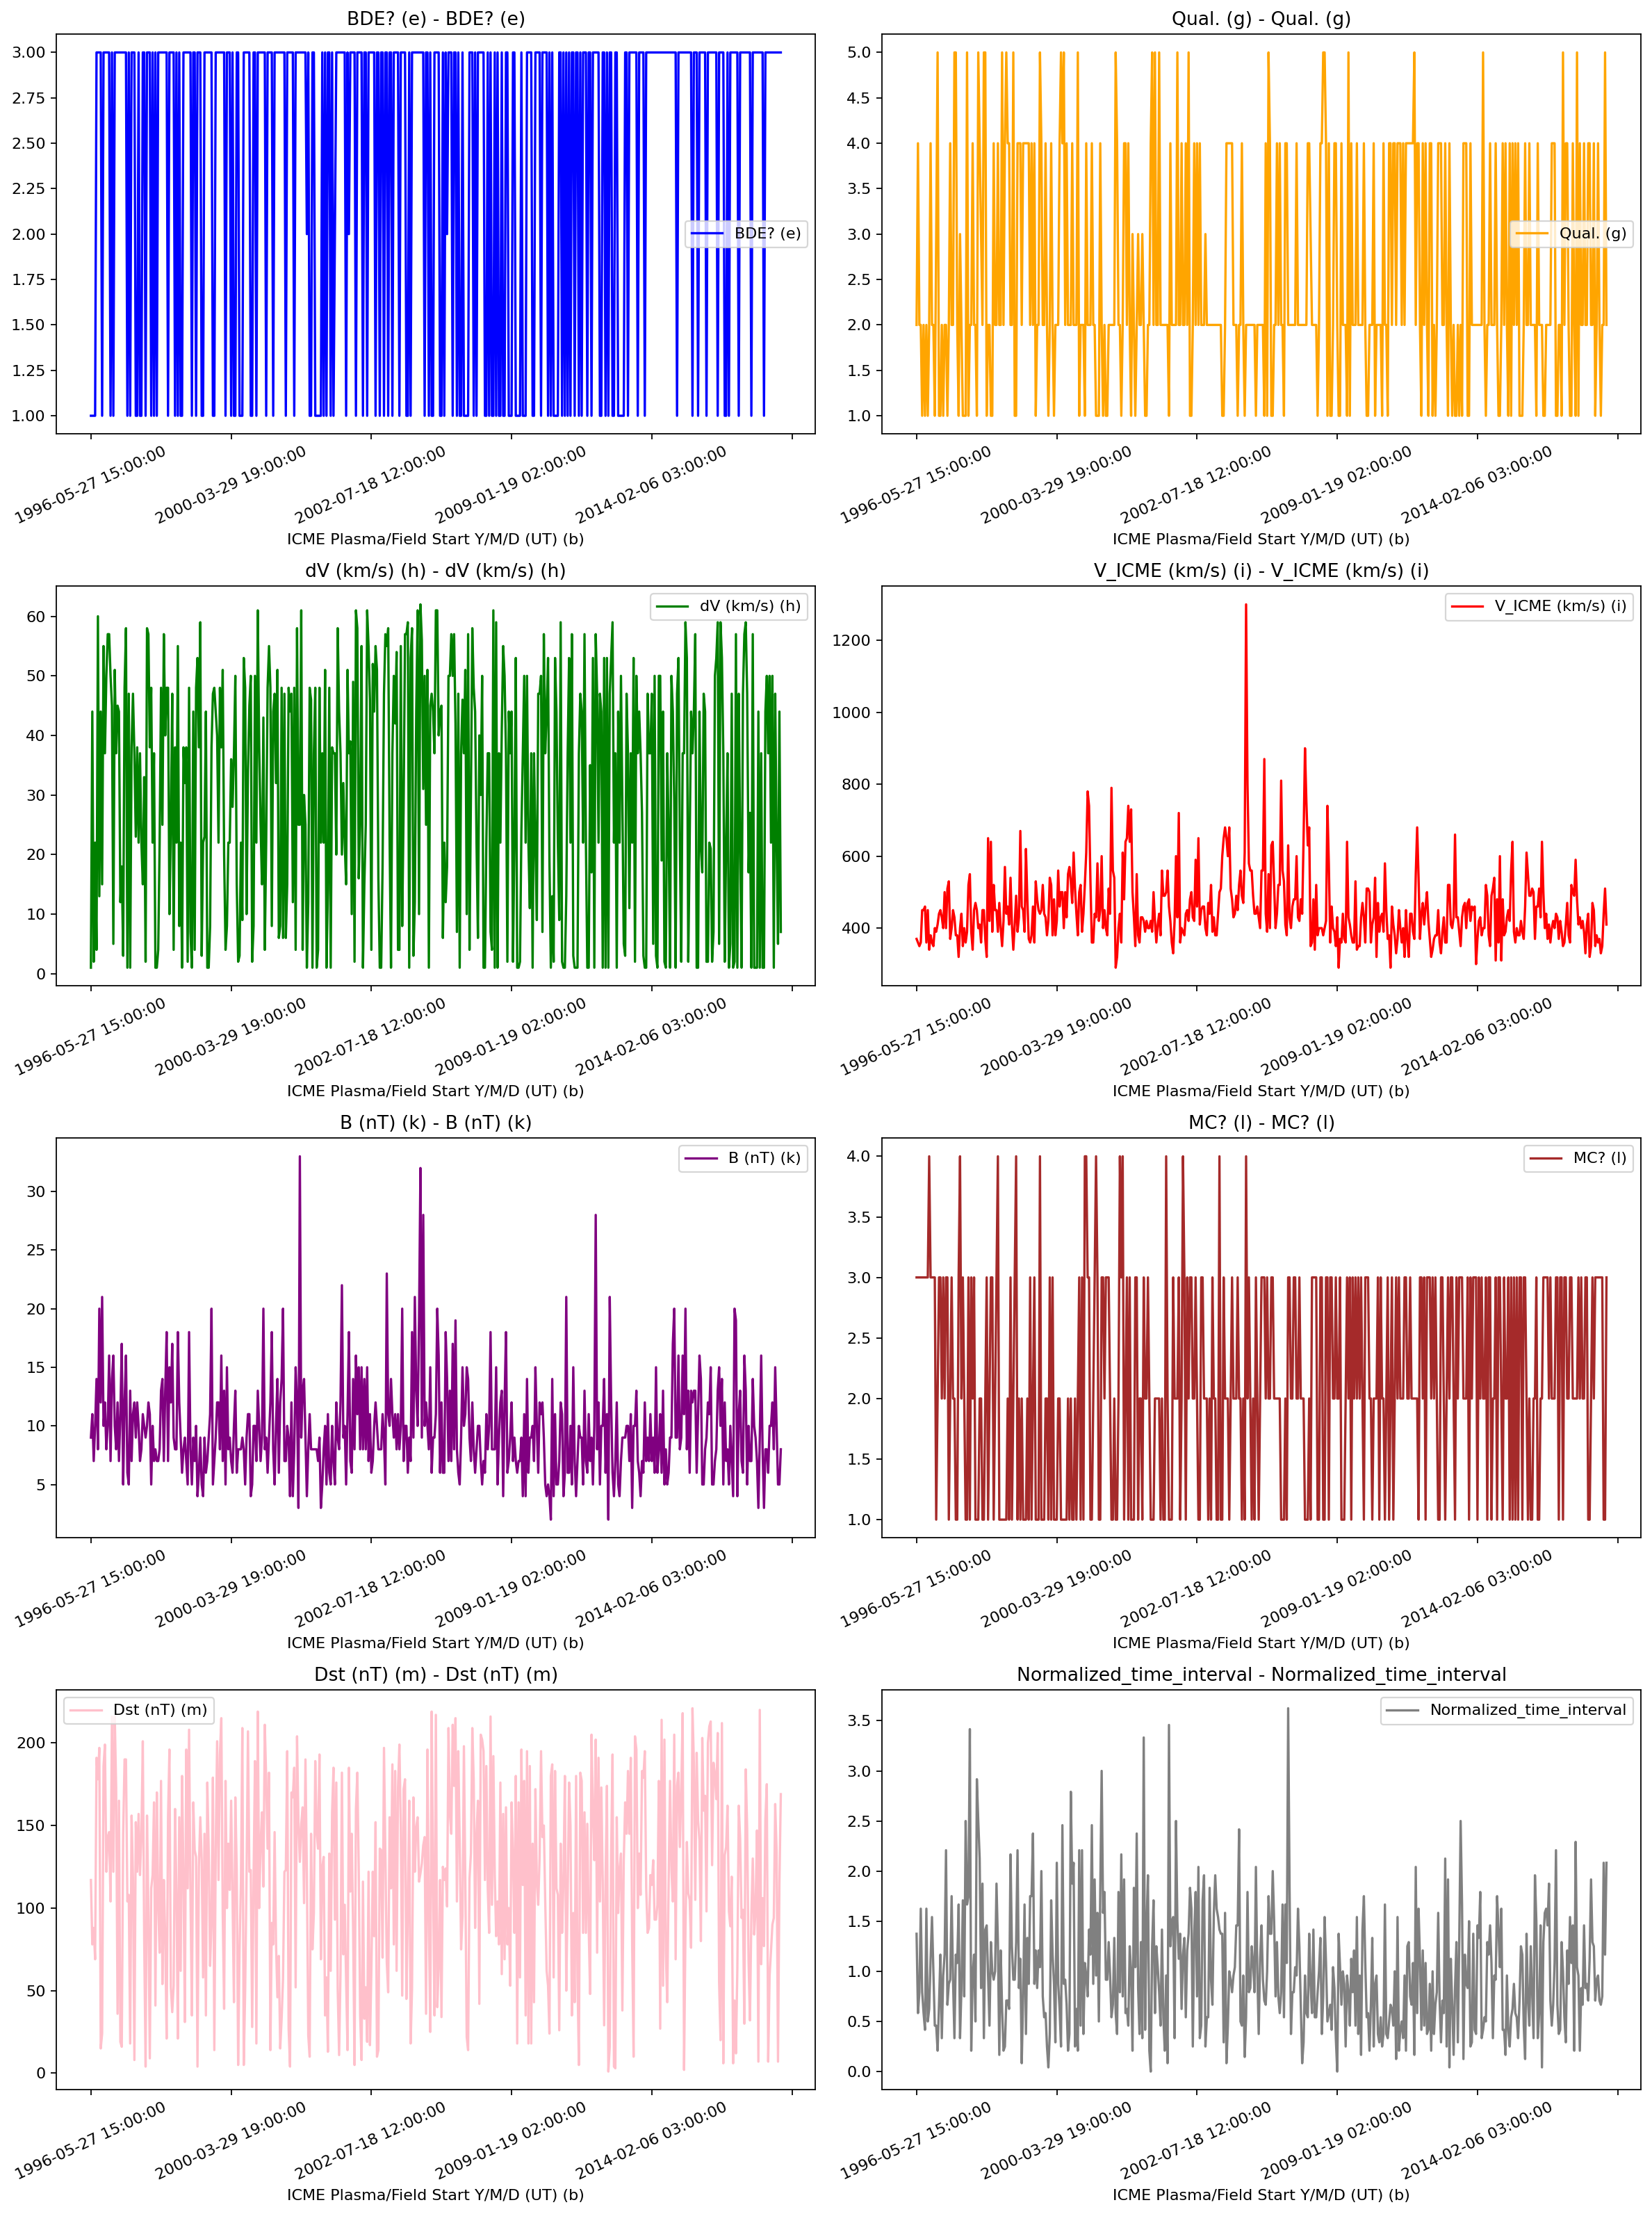

In [30]:
titles = ['BDE? (e)', 'Qual. (g)', 'dV (km/s) (h)', 'V_ICME (km/s) (i)',
       'B (nT) (k)', 'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval']

feature_keys = ['BDE? (e)', 'Qual. (g)', 'dV (km/s) (h)', 'V_ICME (km/s) (i)',
       'B (nT) (k)', 'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval']

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
]

date_time_key = "ICME Plasma/Field Start Y/M/D (UT) (b)"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Normalizing data

In [31]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7
0,-1.398798,-0.389291,-1.507188,-0.862626,-0.214904,1.060704,0.043285,0.499631
1,-1.398798,1.275601,0.664612,-0.952263,0.238930,1.060704,-0.605988,-0.717190
2,-1.398798,-0.389291,-1.456681,-1.041900,-0.668738,1.060704,-0.439508,-0.396974
3,-1.398798,-0.389291,-0.446541,-0.952263,0.012013,1.060704,-0.755820,0.883890
4,0.724378,-1.221737,-1.355667,-0.145529,0.919682,1.060704,1.275238,-0.396974


In [32]:
features.shape

(493, 8)

## Train and Val

In [33]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [34]:
train_data.shape

(340, 8)

In [35]:
val_data.shape

(153, 8)

In [36]:
train_data.head()

,0,1,2,3,4,5,6,7
0,-1.398798,-0.389291,-1.507188,-0.862626,-0.214904,1.060704,0.043285,0.499631
1,-1.398798,1.275601,0.664612,-0.952263,0.238930,1.060704,-0.605988,-0.717190
2,-1.398798,-0.389291,-1.456681,-1.041900,-0.668738,1.060704,-0.439508,-0.396974
3,-1.398798,-0.389291,-0.446541,-0.952263,0.012013,1.060704,-0.755820,0.883890
4,0.724378,-1.221737,-1.355667,-0.145529,0.919682,1.060704,1.275238,-0.396974


In [37]:
start = past + future
end = start + train_split
print('start = ', start)
print('end = ', end)
print('train_split = ', train_split)
sequence_length = int(past / step)
print('sequence_length = ', sequence_length)

start =  61
end =  401
train_split =  340
sequence_length =  60


## Choose target column

In [38]:
features.iloc[start:end][[3]]

,3
61,-1.041900
62,-0.414440
63,0.930117
64,-0.235166
65,-0.055891
...,...
396,-0.055891
397,-0.145529
398,-0.055891
399,-1.490086


In [39]:
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[3]]

<AxesSubplot:>

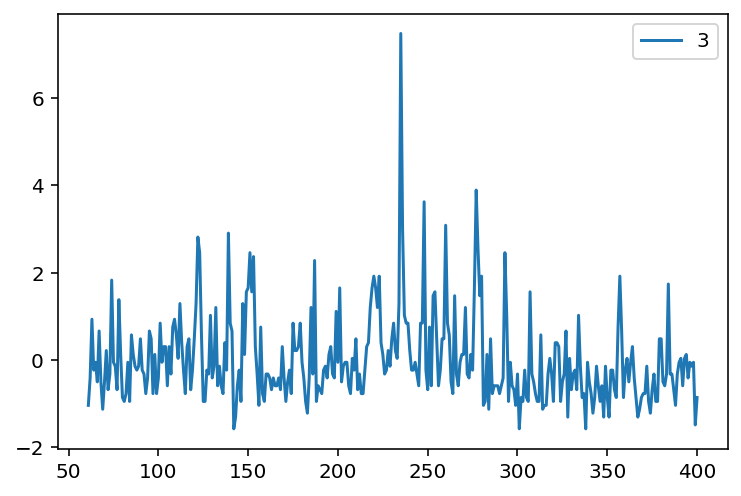

In [40]:
y_train.plot()

In [41]:
len(x_train)

340

In [42]:
print('x_train.shape', x_train.shape,
      '\ny_train.shape', y_train.shape)

x_train.shape (340, 7) 
y_train.shape (340, 1)


## Preprocessing data

In [43]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(x_train,
                                                                  y_train,
                                                                  sequence_length=sequence_length,
                                                                  sampling_rate=step,
                                                                  batch_size=batch_size,
                                                                  )

2021-10-30 18:57:30.656291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
# dataset_train
# print(val_data)

In [45]:
x_end = len(val_data) - past - future
# print('x_end ', x_end)
label_start = train_split + past + future
# print('label_start ', label_start)

In [46]:
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[3]]

<AxesSubplot:>

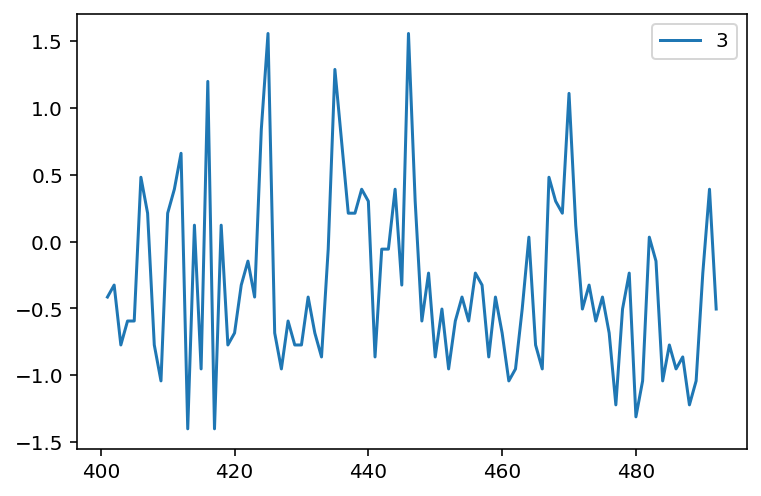

In [47]:
y_val.plot()

In [48]:
# train_split
# x_val.shape
# y_val.shape
# sequence_length
# batch_size
# step

In [93]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(x_val,
                                                                y_val,
                                                                sequence_length=sequence_length,
                                                                sampling_rate=step,
                                                                batch_size=batch_size,
                                                                )


for batch in dataset_train.take(-1):
    inputs, targets = batch

# print("Input shape:", inputs.numpy().shape)
# print("Target shape:", targets.numpy().shape)


print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (25, 60, 7)
Target shape: (25, 1)


In [109]:
shape=(inputs.shape[1], inputs.shape[2])
shape

(60, 7)

## Assemble keras model

In [111]:
from tensorflow.keras import layers


In [116]:
# # https://keras.io/guides/working_with_rnns/
# model = keras.Sequential()
# model.add(layers.Embedding(input_dim=60, output_dim=7))

# # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
# model.add(layers.GRU(256, return_sequences=True))

# # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
# model.add(layers.SimpleRNN(128))

# model.add(layers.Dense(1))


# model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
#               loss="mse")

# model.summary()

In [117]:
inputs = keras.layers.Input(shape=(inputs.shape[1], 
                                   inputs.shape[2]))

lstm_out = keras.layers.LSTM(8)(inputs)

outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="mse")

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 60, 7)]           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 8)                 512       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


## Fit the model

In [118]:
path_checkpoint = "../Models/LSTM_Multivariate_P03_05.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, 
                                            patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
                                                    monitor="val_loss",
                                                    filepath=path_checkpoint,
                                                    verbose=1,
                                                    #save_weights_only=True,
                                                    save_best_only=True,
                                                )

history = model.fit(
                    dataset_train,
                    epochs=10,
                    validation_data=dataset_val,
                    shuffle=False,
                    callbacks=[modelckpt_callback],#es_callback, 
                )

Epoch 1/10
2/2 [==============================] - 2s 403ms/step - loss: 1.1386 - val_loss: 0.5802

Epoch 00001: val_loss improved from inf to 0.58022, saving model to ../Models/LSTM_Multivariate_P03_05.h5
Epoch 2/10
2/2 [==============================] - 0s 91ms/step - loss: 1.1339 - val_loss: 0.5777

Epoch 00002: val_loss improved from 0.58022 to 0.57770, saving model to ../Models/LSTM_Multivariate_P03_05.h5
Epoch 3/10
2/2 [==============================] - 0s 90ms/step - loss: 1.1305 - val_loss: 0.5750

Epoch 00003: val_loss improved from 0.57770 to 0.57503, saving model to ../Models/LSTM_Multivariate_P03_05.h5
Epoch 4/10
2/2 [==============================] - 0s 92ms/step - loss: 1.1272 - val_loss: 0.5724

Epoch 00004: val_loss improved from 0.57503 to 0.57239, saving model to ../Models/LSTM_Multivariate_P03_05.h5
Epoch 5/10
2/2 [==============================] - 0s 84ms/step - loss: 1.1241 - val_loss: 0.5698

Epoch 00005: val_loss improved from 0.57239 to 0.56983, saving model to .

## Load the pre-trained model

In [121]:
from tensorflow.keras.models import *

In [122]:
path_1 = '../Models/LSTM_Multivariate_P03_05.h5'
model = keras.models.load_model(path_1)

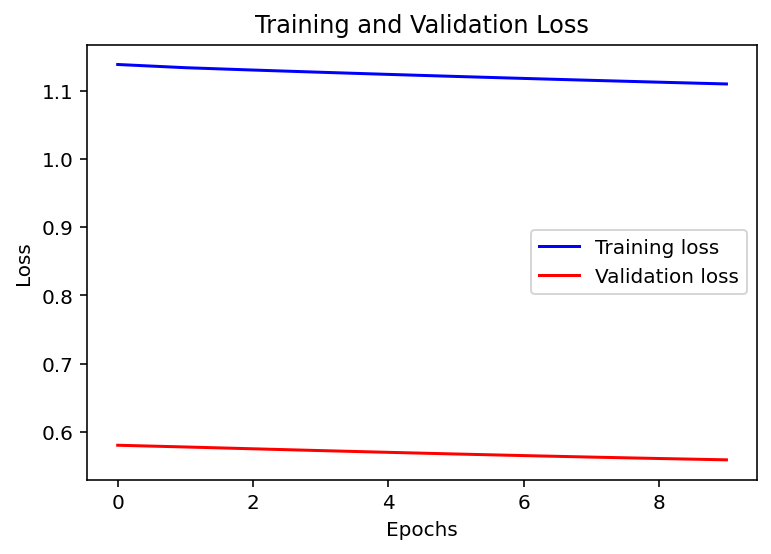

In [123]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [124]:
def show_plot(plot_data, delta, title):
    plt.figure(figsize=(20,8))
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
            
            
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
#     plt.show()
    
    return

## GIF

In [130]:
real_values = []
predited_values = []

@gif.frame
def plott(i):
#     real_values = []
#     predited_values = []

    for x, y in dataset_val.take(-1):



#         for i in range(1,33):
#             print(i)
        show_plot(
            [x[i][:, 3].numpy(), y[i].numpy(), model.predict(x)[i]],
            1,
            "Single Step Prediction",
        )

        real_values.append(y[i].numpy())
        predited_values.append(model.predict(x)[i])
        
        
        
        

In [133]:
real_values

[array([-0.86262591])]

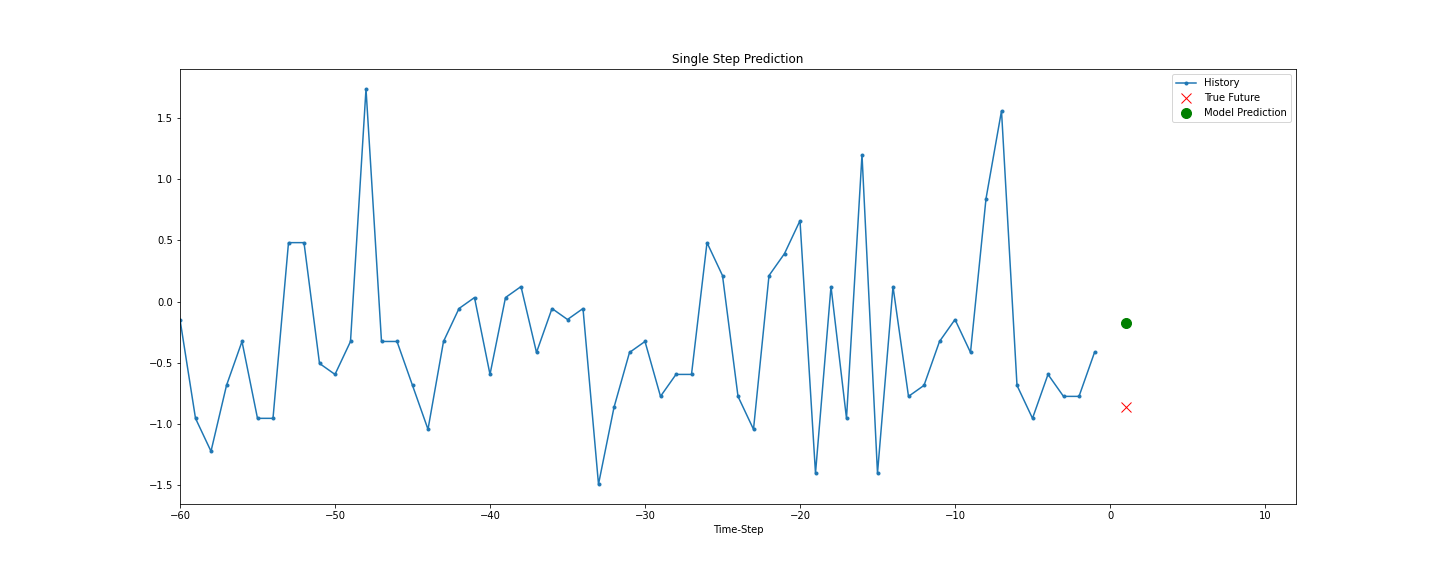

In [132]:
plott(32)

In [134]:
frames = []    
for i in tqdm(range(1,33)):

    
    frame = plott(i)
    frames.append(frame)

100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  3.12it/s]


In [75]:
gif.save(frames, "../Figures/LSTM_multi_P3_5.gif", duration=2)

<p align="center">
  <img width="1200" src="../Figures/LSTM_multi_P3_5.gif" >
</p>

In [135]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(real_values, predited_values)
coefficient_of_dermination

-0.1633637867450939

In [136]:
rs2 = round(coefficient_of_dermination,2)
rs2

-0.16

In [142]:
lstm_P03_05_performance = {'R_sq': r2_score(real_values, predited_values),
                                'rmse': sqrt(mean_squared_error(real_values, predited_values))}

# https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type
with open("../Data/lstm_P03_05_performance.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    json.dump(lstm_P03_05_performance, f, indent=2)

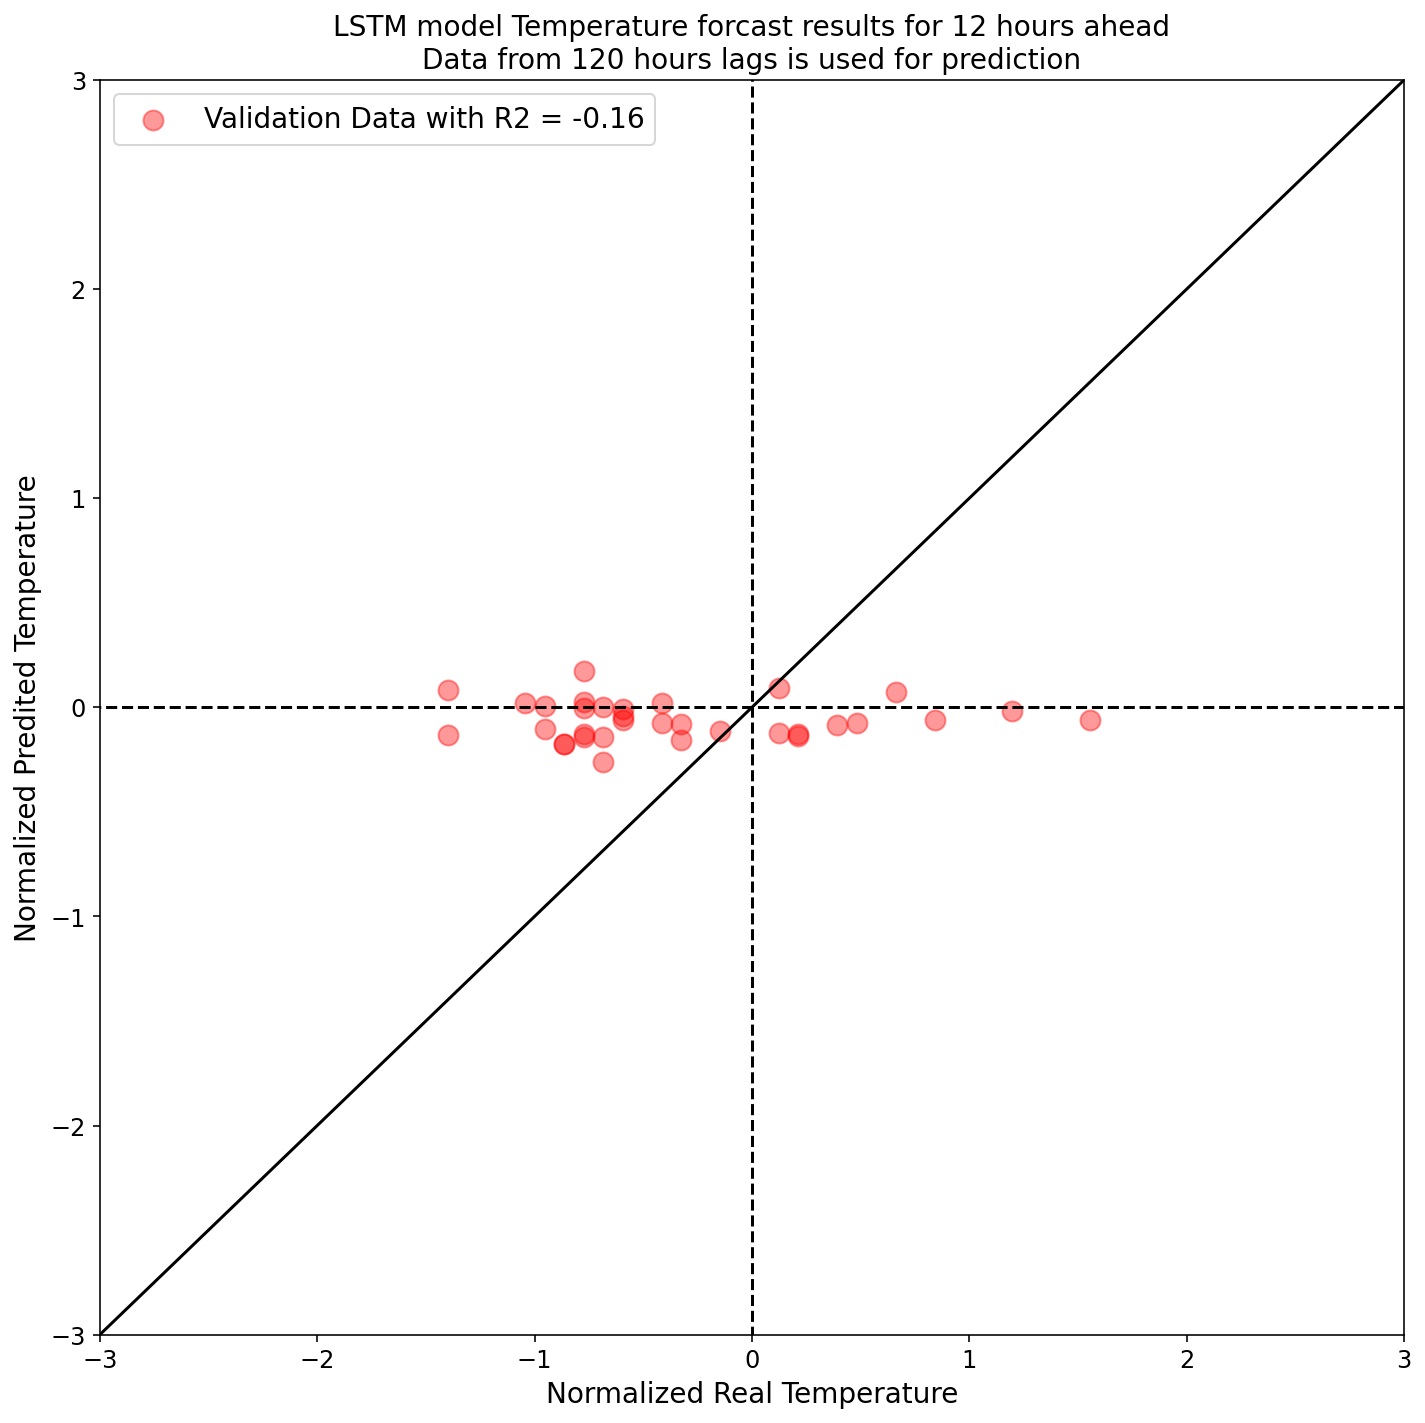

In [137]:
plt.figure(figsize=(10,10))

plt.scatter(real_values, predited_values, color='r', 
            alpha=0.4, label=f'Validation Data with R2 = {rs2}',s=100)
plt.xlabel("Normalized Real Temperature", fontsize=14)
plt.ylabel("Normalized Predited Temperature", fontsize=14)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.axline([0, 0], [1, 1], color ='k')
plt.hlines(0, -4, 4, linestyles="--", color ='k')
plt.vlines(0, -4, 4, linestyles="--", color ='k')

plt.xlim(-3,3), plt.ylim(-3,3)

plt.title("LSTM model Temperature forcast results for 12 \
hours ahead\nData from 120 hours lags is used for prediction", fontsize=14)

plt.tight_layout()
plt.legend(fontsize=14)

# plt.savefig("../Figures/" + section_fig_main_title + "LSTM12HoursAhead.png")